0) Setup

In [2]:
import jax
import jax.numpy as jnp
from jax import random
import matplotlib.pyplot as plt

def wrap_angle(theta):
    return (theta + jnp.pi) % (2 * jnp.pi) - jnp.pi

1) 1DoF Pendulum (differentiable sim)

In [3]:
def pend1_params():
    return dict(g=9.81, l=1.0, I=1.0, b=0.05, dt=0.02)

def pend1_step(state, u, p):
    theta, omega = state
    g, l, I, b, dt = p["g"], p["l"], p["I"], p["b"], p["dt"]

    domega = -(g / l) * jnp.sin(theta) + (u / I) - b * omega
    omega2 = omega + dt * domega
    theta2 = wrap_angle(theta + dt * omega2)
    return jnp.array([theta2, omega2])

def pend1_cost(state, u, u_weight=0.001):
    # stabilize at upright: theta=0, omega=0
    theta, omega = state
    return theta**2 + 0.1 * omega**2 + u_weight * (u**2)

In [4]:
def rollout_pend1(policy_apply, policy_params, key, x0, T, p, action_scale=2.0):
    """
    policy_apply(params, key, state) -> (u, logp)
    """
    def step_fn(carry, _):
        x, k = carry
        k, sub = random.split(k)
        u, logp = policy_apply(policy_params, sub, x)
        u = jnp.clip(u, -action_scale, action_scale)
        x_next = pend1_step(x, u, p)
        c = pend1_cost(x, u)
        return (x_next, k), (x, u, logp, c)

    (xT, _), (xs, us, logps, cs) = jax.lax.scan(step_fn, (x0, key), None, length=T)
    return xs, us, logps, cs


2) 2DoF Double Pendulum with actuation (differentiable sim)

In [5]:
def pend2_params():
    return dict(
        g=9.81,
        m1=1.0, m2=1.0,
        l1=1.0, l2=1.0,
        b1=0.05, b2=0.05,
        dt=0.01
    )

def pend2_step(state, u, p):
    th1, th2, w1, w2 = state
    u1, u2 = u
    g, m1, m2, l1, l2, b1, b2, dt = p["g"], p["m1"], p["m2"], p["l1"], p["l2"], p["b1"], p["b2"], p["dt"]

    d = th1 - th2
    c, s = jnp.cos(d), jnp.sin(d)

    # Mass matrix M(th)
    M11 = (m1 + m2) * l1**2
    M12 = m2 * l1 * l2 * c
    M21 = M12
    M22 = m2 * l2**2
    M = jnp.array([[M11, M12],
                   [M21, M22]])

    # Coriolis/centrifugal-like terms (C)
    # derived for point-mass double pendulum in relative-angle form
    C1 = m2 * l1 * l2 * s * (w2**2)
    C2 = -m2 * l1 * l2 * s * (w1**2)

    # Gravity terms (G)
    G1 = (m1 + m2) * g * l1 * jnp.sin(th1)
    G2 = m2 * g * l2 * jnp.sin(th2)

    # Damping
    D = jnp.array([b1 * w1, b2 * w2])

    # Solve for accelerations
    rhs = jnp.array([u1, u2]) - jnp.array([C1 + G1, C2 + G2]) - D
    acc = jnp.linalg.solve(M, rhs)  # [ddth1, ddth2]

    w1n = w1 + dt * acc[0]
    w2n = w2 + dt * acc[1]
    th1n = wrap_angle(th1 + dt * w1n)
    th2n = wrap_angle(th2 + dt * w2n)
    return jnp.array([th1n, th2n, w1n, w2n])

def pend2_cost(state, u, u_weight=0.001):
    th1, th2, w1, w2 = state
    # stabilize both joints near 0
    return (th1**2 + th2**2) + 0.05*(w1**2 + w2**2) + u_weight*jnp.sum(u**2)

def rollout_pend2(policy_apply, policy_params, key, x0, T, p, action_scale=2.0):
    def step_fn(carry, _):
        x, k = carry
        k, sub = random.split(k)
        u, logp = policy_apply(policy_params, sub, x)  # u is shape (2,)
        u = jnp.clip(u, -action_scale, action_scale)
        x_next = pend2_step(x, u, p)
        c = pend2_cost(x, u)
        return (x_next, k), (x, u, logp, c)

    (xT, _), (xs, us, logps, cs) = jax.lax.scan(step_fn, (x0, key), None, length=T)
    return xs, us, logps, cs


3) Gaussian policy + REINFORCE (works for both)

In [6]:
def init_mlp(sizes, key, scale=0.1):
    keys = random.split(key, len(sizes)-1)
    params = []
    for k, (din, dout) in zip(keys, zip(sizes[:-1], sizes[1:])):
        w = scale * random.normal(k, (din, dout))
        b = jnp.zeros((dout,))
        params.append((w, b))
    return params

def mlp_apply(params, x):
    for i, (w, b) in enumerate(params):
        x = x @ w + b
        if i < len(params)-1:
            x = jnp.tanh(x)
    return x

def init_gaussian_policy(obs_dim, act_dim, key):
    k1, k2 = random.split(key)
    net = init_mlp([obs_dim, 64, 64, act_dim], k1)
    log_std = -0.5 * jnp.ones((act_dim,))  # start somewhat stochastic
    return {"net": net, "log_std": log_std}

def gaussian_policy_apply(params, key, obs):
    mu = mlp_apply(params["net"], obs)
    log_std = params["log_std"]
    std = jnp.exp(log_std)

    eps = random.normal(key, mu.shape)
    a = mu + std * eps

    # log N(a | mu, std^2)
    logp = -0.5 * jnp.sum(((a - mu) / std)**2 + 2*log_std + jnp.log(2*jnp.pi))
    return a, logp


In [7]:
def discounted_returns(costs, gamma=0.99):
    # costs shape (T,)
    def scan_fn(G, c):
        G_new = c + gamma * G
        return G_new, G_new
    _, Gs_rev = jax.lax.scan(scan_fn, 0.0, costs[::-1])
    return Gs_rev[::-1]

def reinforce_loss(policy_params, rollout_fn, key, x0, T, env_p, gamma=0.99):
    xs, us, logps, costs = rollout_fn(gaussian_policy_apply, policy_params, key, x0, T, env_p)
    G = discounted_returns(costs, gamma=gamma)

    # baseline: mean return (simple, differentiable, reduces variance a bit)
    adv = G - jnp.mean(G)

    # We minimize expected return (cost), so objective ~ sum( logp * adv )
    # gradient descent on this equals policy gradient ascent on -cost.
    loss = jnp.mean(logps * jax.lax.stop_gradient(adv))
    return loss, (jnp.sum(costs), xs)


In [8]:
@jax.jit
def sgd_step(params, grads, lr=3e-3):
    def upd(p, g):
        return p - lr * g
    # tree_map works on dict/list/tuples
    return jax.tree_util.tree_map(upd, params, grads)

def train_reinforce_1d(seed=0, iters=300, T=200):
    key = random.PRNGKey(seed)
    p = pend1_params()
    x0 = jnp.array([0.5, 0.0])  # start away from upright

    params = init_gaussian_policy(obs_dim=2, act_dim=1, key=key)
    # adapt apply to return scalar action for 1D
    def policy_apply_1d(pp, k, obs):
        a, logp = gaussian_policy_apply(pp, k, obs)
        return a[0], logp  # scalar torque

    def rollout_fn(policy_apply, policy_params, key, x0, T, env_p):
        # wrap the 1D policy into the rollout
        def step_fn(carry, _):
            x, k = carry
            k, sub = random.split(k)
            u, logp = policy_apply_1d(policy_params, sub, x)
            u = jnp.clip(u, -2.0, 2.0)
            x_next = pend1_step(x, u, env_p)
            c = pend1_cost(x, u)
            return (x_next, k), (x, u, logp, c)
        (xT, _), (xs, us, logps, cs) = jax.lax.scan(step_fn, (x0, key), None, length=T)
        return xs, us, logps, cs

    losses = []
    returns = []
    for i in range(iters):
        key, sub = random.split(key)
        (L, (J, _)), grads = jax.value_and_grad(reinforce_loss, has_aux=True)(params, rollout_fn, sub, x0, T, p)
        params = sgd_step(params, grads, lr=3e-3)
        losses.append(float(L))
        returns.append(float(J))
        if (i+1) % 50 == 0:
            print(f"iter {i+1:4d} | loss {losses[-1]: .4f} | episode_cost {returns[-1]: .2f}")
    return params, jnp.array(losses), jnp.array(returns), p, x0, T

def train_reinforce_2d(seed=0, iters=400, T=300):
    key = random.PRNGKey(seed)
    p = pend2_params()
    x0 = jnp.array([0.8, -0.6, 0.0, 0.0])

    params = init_gaussian_policy(obs_dim=4, act_dim=2, key=key)

    losses = []
    returns = []
    for i in range(iters):
        key, sub = random.split(key)
        (L, (J, _)), grads = jax.value_and_grad(reinforce_loss, has_aux=True)(
            params, rollout_pend2, sub, x0, T, p
        )
        params = sgd_step(params, grads, lr=2e-3)
        losses.append(float(L))
        returns.append(float(J))
        if (i+1) % 50 == 0:
            print(f"iter {i+1:4d} | loss {losses[-1]: .4f} | episode_cost {returns[-1]: .2f}")
    return params, jnp.array(losses), jnp.array(returns), p, x0, T


4) Run + Plot (1DoF example)

iter   50 | loss  0.3805 | episode_cost  56.87
iter  100 | loss -0.5601 | episode_cost  56.15
iter  150 | loss  0.9952 | episode_cost  58.23
iter  200 | loss -0.1289 | episode_cost  48.47
iter  250 | loss -0.1708 | episode_cost  51.35
iter  300 | loss  0.2851 | episode_cost  55.80


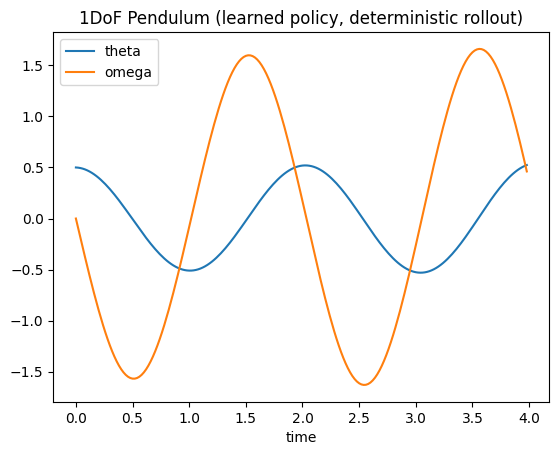

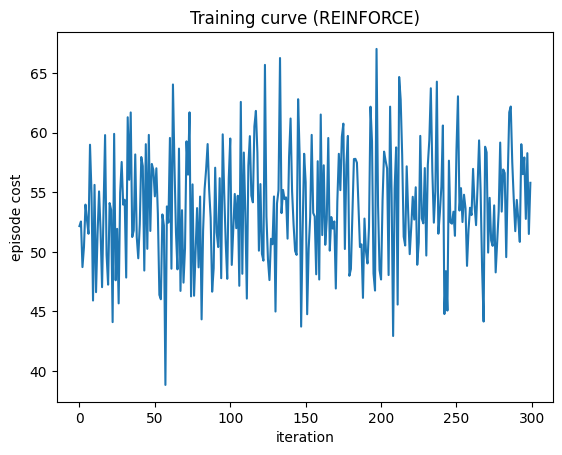

In [9]:
params, losses, ep_costs, p, x0, T = train_reinforce_1d(seed=0, iters=300, T=200)

# final rollout (use mean action: set noise=0 by sampling eps=0)
def deterministic_action(params, obs):
    mu = mlp_apply(params["net"], obs)
    return mu[0]

def rollout_det_1d(params, x0, T, p):
    def step_fn(x, _):
        u = jnp.clip(deterministic_action(params, x), -2.0, 2.0)
        x2 = pend1_step(x, u, p)
        return x2, x
    _, xs = jax.lax.scan(step_fn, x0, None, length=T)
    return xs

xs = rollout_det_1d(params, x0, T, p)
t = jnp.arange(T) * p["dt"]

plt.figure()
plt.plot(t, xs[:,0], label="theta")
plt.plot(t, xs[:,1], label="omega")
plt.legend(); plt.xlabel("time"); plt.title("1DoF Pendulum (learned policy, deterministic rollout)")
plt.show()

plt.figure()
plt.plot(ep_costs)
plt.xlabel("iteration"); plt.ylabel("episode cost"); plt.title("Training curve (REINFORCE)")
plt.show()


5) Run + Plot (2DoF example)

iter   50 | loss  1.3507 | episode_cost  308.90
iter  100 | loss  1.3826 | episode_cost  290.82
iter  150 | loss  0.1679 | episode_cost  295.76
iter  200 | loss -0.1459 | episode_cost  301.42
iter  250 | loss -2.9243 | episode_cost  296.40
iter  300 | loss -1.2105 | episode_cost  296.61
iter  350 | loss  1.2563 | episode_cost  293.14
iter  400 | loss -0.9306 | episode_cost  300.61


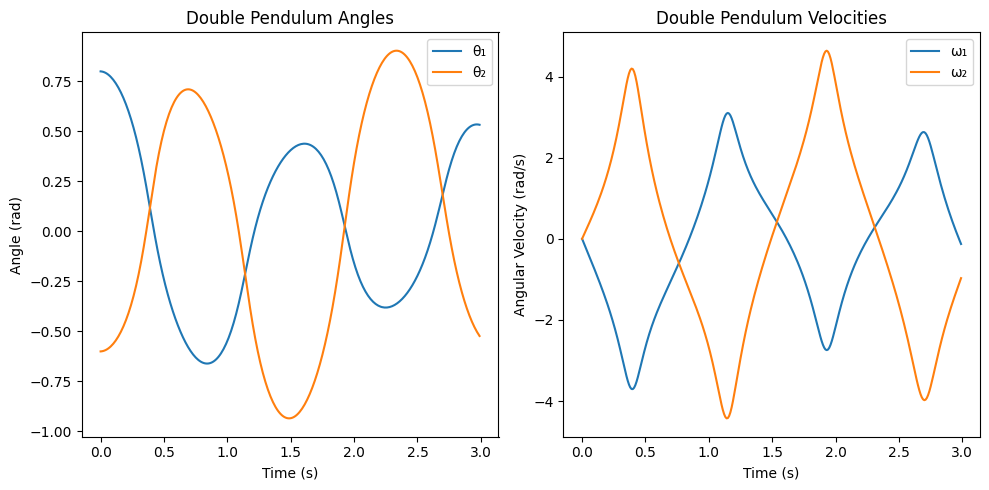

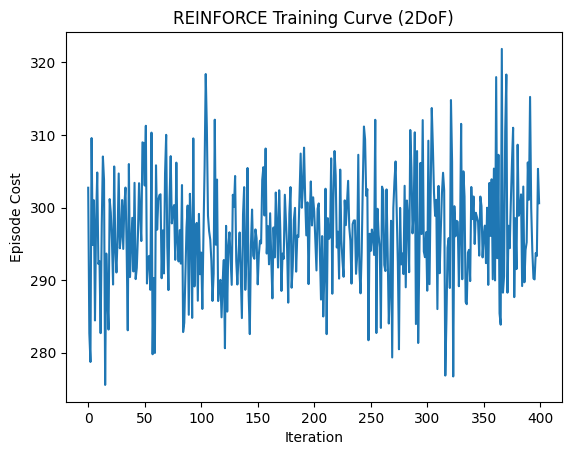

In [10]:
# Train policy (REINFORCE)
params, losses, ep_costs, p, x0, T = train_reinforce_2d(
    seed=0,
    iters=400,
    T=300
)

# Deterministic policy (use mean action, no sampling)
def deterministic_action_2d(params, obs):
    mu = mlp_apply(params["net"], obs)
    return jnp.clip(mu, -2.0, 2.0)

# Rollout with learned policy (no noise)
def rollout_det_2d(params, x0, T, p):
    def step_fn(x, _):
        u = deterministic_action_2d(params, x)
        x_next = pend2_step(x, u, p)
        return x_next, x
    _, xs = jax.lax.scan(step_fn, x0, None, length=T)
    return xs

# Run rollout
xs = rollout_det_2d(params, x0, T, p)
t = jnp.arange(T) * p["dt"]

# Plot joint angles and velocities
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(t, xs[:, 0], label="θ₁")
plt.plot(t, xs[:, 1], label="θ₂")
plt.xlabel("Time (s)")
plt.ylabel("Angle (rad)")
plt.title("Double Pendulum Angles")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(t, xs[:, 2], label="ω₁")
plt.plot(t, xs[:, 3], label="ω₂")
plt.xlabel("Time (s)")
plt.ylabel("Angular Velocity (rad/s)")
plt.title("Double Pendulum Velocities")
plt.legend()

plt.tight_layout()
plt.show()

# Plot training curve
plt.figure()
plt.plot(ep_costs)
plt.xlabel("Iteration")
plt.ylabel("Episode Cost")
plt.title("REINFORCE Training Curve (2DoF)")
plt.show()
